# S metaheuristike (single solution metaheuristics)
Kod s metaheuristika imamo jedno rešenje koje menjamo i poboljšavamo kroz iteracije, za razliku od p metaheuristika gde imamo čitavu populaciju rešenja.
Neki primeri s metaheuristika su:
- simulirano kaljenje (Simulated Annealing),
- metoda promenljivih okolina (Variable Neighborhood Search, VNS),
- iterirana lokalna pretraga (Iterated Local Search),
- tabu pretraga (Tabu Search).

Prve dve će biti obrađene u nastavku sa primenom na prost lokacijski problem (UFLP).

### Prost lokacijski problem (Uncapacitated Facility Location Problem - UFLP)
Zadato je $N$ potencijalnih lokacija objekata (ustanova), npr. škola ili bolnica. Za svaku lokaciju $j$ postoji cena izgradnje objekta $f_j$.
Postoji $M$ korisnika i za svakog korisnika $i$ i svaki objekat $j$ zadata je cena pridruživanja korisnika resursu $c_{ij}$.
Svaki korisnik mora da bude dodeljen tačno jednom objektu.
Cilj je odrediti koje objekte treba izgraditi tako da ukupna cena (zbir cena izgrađenih objekata i cena pridruživanja korisnika resursima) bude minimalna.

In [23]:
import random

In [24]:
from typing import List, Tuple


def read_line_of_ints(line: str) -> List[int]:
    return [int(x) for x in line.split()]

def read_data(file_path: str) -> Tuple[List[List[int]], List[int]]:
    """
    Read data from file in the following format:
    num_users, num_resources
    num_users x num_resources cost matrix of assigning user i to resource j
    num_resources cost array of building resource j
    """
    with open(file_path, 'r') as f:
        user_resource_cost = []
        for i, line in enumerate(f):
            if i == 0:
                num_users, num_resources = read_line_of_ints(line)
            elif i <= num_users:
                user_resource_cost.append(read_line_of_ints(line))
            else:
                resource_cost = read_line_of_ints(line)
        
        return user_resource_cost, resource_cost


In [25]:
user_resource_cost, resource_cost = read_data('../../2023_2024/live/03_s_metaheuristics/uflp1.txt')

In [26]:
# mozemo da napravimo alijas za tip, ali, naravno, ne moramo
Solution = List[bool]

Fitnes generalno predstavlja prilagođenost, tako da bi bilo prirodno da želimo što veći fitnes.
Verovatno bi bilo ispravnije da ovo zovemo vrednost funkcije cilja...

In [27]:
def calc_fitness(solution: Solution, user_resource_cost: List[List[int]], resource_cost: List[int]) -> int:
    """Calculate fitness of the given solution"""

    # TODO optimizacija - nekakvo stablo da bi slozenost bila logM

    # ne raditi ovo uvek, ako ima vise nedopustivih resenja moze da se zaglavi lako
    # jer bi tada sva nedopustiva resenja imala isti fitnes (inf)
    if not any(solution):
        return float('inf')
    built_resources_cost = sum(c for i, c in enumerate(resource_cost) if solution[i])
    user_cost = sum(min(x for i, x in enumerate(c) if solution[i]) for c in user_resource_cost)
    return built_resources_cost + user_cost

Kod nediferencijabilnih funkcija, kakva je i funkcija cilja UFLP-a, ne možemo da koristimo gradijent da odredimo pravac u kome funkcija opada.
U ovakvim situacijama koristimo lokalnu pretragu za pronalazak lokalnog minimuma u okolini trenutnog rešenja.

Lokalna pretraga nije metaheuristika za sebe, već se koristi kao gradivni element, zaslužan za intenzifikaciju, različitih metaheuristika.

U nastavku su implementirane dve vrste lokalne pretrage:
- jedna zasnovana na prvom poboljšanju (first improvement) - prihvatamo prvo susedno rešenje koje je bolje od trenutnog;
- druga zasnovana na najboljem poboljšanju (best improvement) - prolazimo kroz sva susedna rešenja i prihvatamo najbolje od njih.

Obe su sistematične - prolazimo kroz sva susedna rešenja. Lokalna pretraga može da bude i stohastička ako ne idemo redom kroz susedna rešenja, već ih na neki način nasumično biramo.

In [28]:
def local_search_invert_first_improvement(solution: List[bool], fitness: int, user_resource_cost, resource_cost):
    """
    Finds a local minimum starting from the given solution using `invert` operator (flipping bit by bit).
    At each step chooses the FIRST possible improvement from the neighborhood.

    Returns new fitness; solution is changed in place.
    """
    improved = True
    while improved:
        improved = False
        indices = list(range(len(solution)))
        # ako ne bismo shuffle-ovali, postojala bi pristranost prema nizim indeksima
        random.shuffle(indices)
        for i in indices:
            solution[i] = not solution[i]
            # recalc_fitness treba da bude posebna funkcija u kojoj ne pravimo od nule stablo
            # vec parcijalno racunamo fitnes na osnovu trenutne vrednosti i male promene koju smo napravili
            new_fitness = calc_fitness(solution, user_resource_cost, resource_cost)
            if new_fitness < fitness:
                improved = True
                fitness = new_fitness
                break
            else:
                solution[i] = not solution[i]
    return fitness

In [29]:
def local_search_invert_best_improvement(solution: List[bool], fitness: int, user_resource_cost, resource_cost):
    """
    Finds a local minimum starting from the given solution using `invert` operator (flipping bit by bit).
    At each step chooses the BEST possible improvement from the neighborhood.

    Returns new fitness; solution is changed in place.
    """
    improved = True
    while improved:
        improved = False
        best_fitness = fitness
        best_idx = -1
        for i in range(len(solution)):
            # invert temporarily
            solution[i] = not solution[i]
            
            # recalc_fitness treba da bude posebna funkcija u kojoj ne pravimo od nule stablo
            # vec parcijalno racunamo fitnes na osnovu trenutne vrednosti i male promene koju smo napravili
            new_fitness = calc_fitness(solution, user_resource_cost, resource_cost)
            if new_fitness < best_fitness:
                best_fitness = new_fitness
                best_idx = i
            
            # revert to previous solution
            solution[i] = not solution[i]

        if best_idx != -1:
            # actually invert
            solution[best_idx] = not solution[best_idx]
            improved = True

    return fitness

In [30]:
# TODO za domaci
# swap - zameni dva bita od kojih je jedan 1, a drugi 0
def local_search_swap_first_improvement():
    pass

In [31]:
def local_search_swap_best_improvement():
    pass

In [32]:
solution = [False, True, True]
fitness = calc_fitness(solution, user_resource_cost, resource_cost)
local_search_invert_first_improvement(solution, fitness, user_resource_cost, resource_cost)

41

In [33]:
solution = [False, True, True]
fitness = calc_fitness(solution, user_resource_cost, resource_cost)
local_search_invert_best_improvement(solution, fitness, user_resource_cost, resource_cost)

41

In [34]:
import itertools

In [35]:
for x in itertools.product([True, False], repeat=3):
    print(x)
    # probati LS za svaki moguci ulaz jer mozemo na ovako malom primeru

(True, True, True)
(True, True, False)
(True, False, True)
(True, False, False)
(False, True, True)
(False, True, False)
(False, False, True)
(False, False, False)


# Simulirano kaljenje

Ideja algoritma simuliranog kaljenja (ustaljeni prevod, iako bi možda adekvatniji bio žarenje) dolazi iz kaljenja čelika gde se čelik zagreva na određenu temperaturu i onda postepeno hladi sa ciljem poboljšanja njegovih fizičkih osobina.

Kao kod lokalne pretrage, kada u okolini trenutnog rešenja pronađemo bolje, prelazimo u njega.
Sa druge strane, da se ne bismo uvek zaglavljivali u lokalnom minimumu, imamo i diverzifikaciju - sa određenom verovatnoćom prihvatamo i lošije rešenje.
Ta verovatnoća opada kroz iteracije (slično kao temperatura u realnom kaljenju).
Ideja je da na početku rada algoritma nemamo još uvek neko jako dobro rešenje i želimo da imamo jaču diverzifikaciju da bismo obišli veći deo prostora pretrage, a kasnije u toku rada algoritma smo verovatno pronašli neko dobro rešenje i želimo da ne odemo predaleko, već da bolje istražimo njegovu okolinu.

Uslov zaustavljanja algoritma (slično važi i za ostale algoritme) može da bude neki od sledećih: broj iteracija, broj sekundi, pronađeno dovoljno dobro rešenje, broj iteracija bez poboljšanja; ili njihova kombinacija.

In [36]:
def initialize(num_resources: int):
    """Construct random initial solution"""
    # NOTE: za razlicite probleme koristimo razlicito kodiranje resenja (ne moze uvek niz bitova)
    # i razlicitu verovatnocu
    
    # return [random.random() < 0.5 for i in range(num_resources)]
    return random.choices([True, False], k=num_resources)

In [ ]:
from copy import deepcopy


def simulated_annealing(num_iters: int, user_resource_cost: List[List[int]], resource_cost: List[int]):
    """
    Simulated annealing for Uncapacitated Facility Location Problem.
    Stop condition is the given number of iterations.
    """
    solution = initialize(len(resource_cost))
    fitness = calc_fitness(solution, user_resource_cost, resource_cost)
    # cuvamo najbolje resenje jer resenje iz poslednje iteracije ne mora da bude najbolje do koga smo dosli
    # zato sto nekad prihvatamo i losija resenja
    best_solution = deepcopy(solution)
    best_fitness = fitness
    for it in range(2, num_iters + 2):
        for i in range(len(solution)):
            solution[i] = not solution[i]
            # recalc_fitness treba da bude posebna funkcija u kojoj ne pravimo od nule stablo
            # vec parcijalno racunamo fitnes na osnovu trenutne vrednosti i male promene koju smo napravili
            new_fitness = calc_fitness(solution, user_resource_cost, resource_cost)
            if new_fitness < fitness:
                fitness = new_fitness
                if new_fitness < best_fitness:
                    best_fitness = new_fitness
                    # TODO probati optimizaciju da ne kopiramo uvek
                    best_solution = deepcopy(solution)
                break
            else:
                p = random.random()
                q = 1 / it
                if p < q:
                    fitness = new_fitness
                else:
                    solution[i] = not solution[i]
    return best_solution, best_fitness

In [38]:
simulated_annealing(10, user_resource_cost, resource_cost)

([True, False, False], 34)

### Vizuelizacija nekih od opadajućih funkcija koje možemo da koristimo u simuliranom kaljenju

In [39]:
from matplotlib import pyplot as plt

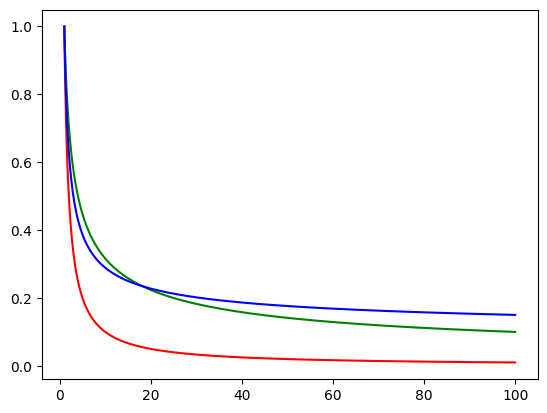

In [40]:
import numpy as np
xs = np.linspace(1, 100, 1000)
plt.plot(xs, 1 / xs, c='red')
plt.plot(xs, 1 / np.sqrt(xs), c='green')
plt.plot(xs, np.log(2) / np.log(xs + 1), c='blue')

# Metoda promenljivih okolina (Variable Neighborhood Search)

VNS se sastoji od dva glavna dela:
- razmrdavanje (shaking) - zadužen za diverzifikaciju, bira nasumičnog suseda iz $k$-te okoline;
- lokalna pretraga - zadužena za intenzifikaciju, odnosno poboljšanje trenutnog rešenja.

Definišemo više okolina od kojih je svaka sledeća šira od prethodne.
Prvo pokušavamo da nađemo bolje rešenje u prvoj okolini, pa ako ne možemo, prelazimo u sledeću.
Kada nađemo bolje rešenje prelazimo u njega i ponavljamo postupak ponovo počevši od prve okoline.
U slučaju da nađemo rešenje istog kvaliteta kao što je trenutno, prihvatamo ga sa verovatnoćom $move\_prob$.

Postoje različite varijacije ovog algoritma, među kojima su i:
- redukovani VNS - gde nemamo lokalnu pretragu, već samo shaking;
- opšti VNS - gde koristimo VNS umesto lokalne pretrage.

### Vizuelizacija rada VNS-a

![images/vns.png](images/vns.png)

In [41]:
def shaking(solution: List[bool], k: int):
    """
    Return a random neighbor from kth neighborhood (k bit flips away).
    """
    # NOTE: okolinu mozemo da definisemo na razlicite nacine - ne mora da bude isti operator kao u lokalnoj pretrazi
    # npr. shaking moze da bude samo remove, a lokalna pretraga swap
    assert len(solution) >= k, f"cannot flip more than {len(solution)} bits"
    indices = random.sample(range(len(solution)), k)
    # [not a if b in indices else a for a, b in enumerate(solution)]
    new_solution = deepcopy(solution)
    for i in indices:
        new_solution[i] = not new_solution[i]
    return new_solution

In [42]:
solution = [False, True, False]
shaking(solution, k=2)

[True, False, False]

In [ ]:
from typing import Callable
from matplotlib import pyplot as plt

def vns(
        user_resource_costs: List[List[int]],
        resource_costs: List[int],
        num_iters: int,
        local_search: Callable[[List[bool], int, List[List[int]], List[int]], int],
        neighborhoods: List[int],
        move_prob: float,
    ):
    """
    Variable Neighborhood Search for Uncapacitated Facility Location Problem.
    Stop condition is the given number of iterations.
    Plots the fitness over iterations.
    """
    # NOTE: ne moramo da saljemo lokalnu pretragu kao argument
    # umesto liste za okoline (argument neighborhoods), mozemo da prosledimo k_min i k_max
    solution = initialize(len(resource_costs))
    fitness = calc_fitness(solution, user_resource_costs, resource_costs)
    fitnesses = []
    for it in range(num_iters):
        for k in neighborhoods:
            new_solution = shaking(solution, k)
            # i ovde bismo mogli da koristimo parcijalno racunanje fitnesa
            new_fitness = calc_fitness(new_solution, user_resource_costs, resource_costs)
            new_fitness = local_search(new_solution, new_fitness, user_resource_costs, resource_costs)
            if new_fitness < fitness or (new_fitness == fitness and random.random() < move_prob):
                fitness = new_fitness
                solution = deepcopy(new_solution)
                break
        fitnesses.append(fitness)

    plt.plot(fitnesses)
    plt.show()
    return solution, fitness

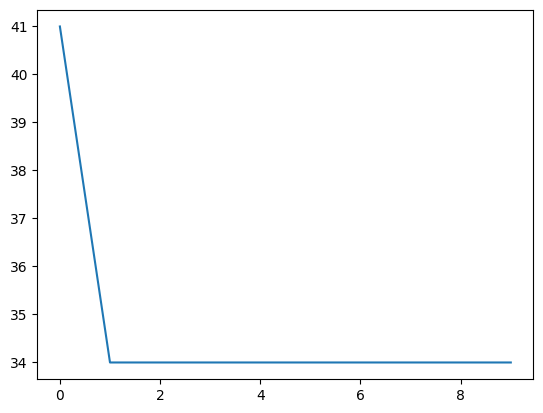

([True, False, False], 34)

In [48]:
vns(
    user_resource_cost,
    resource_cost,
    num_iters=10,
    local_search=local_search_invert_first_improvement,
    neighborhoods=range(1, 3),
    move_prob=0.5,
)

In [49]:
def read_data_bk(file_path: str):
    resource_costs = []
    user_resource_costs = []
    with open(file_path) as f:
        for i, line in enumerate(f):
            if i == 0:
                continue
            elif i == 1:
                num_resources, num_users, _ = read_line_of_ints(line)
            else:
                xs = read_line_of_ints(line)
                resource_costs.append(xs[1])
                user_resource_costs.append(xs[2:])

    user_resource_costs = np.array(user_resource_costs).T.tolist()
    
    return user_resource_costs, resource_costs

In [50]:
user_resource_costs, resource_costs = read_data_bk('../../2023_2024/live/03_s_metaheuristics/BildeKrarup/B/B1.1')

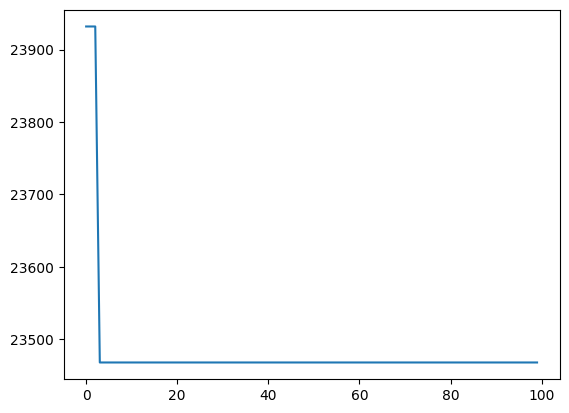

([False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False],
 23468)

In [52]:
vns(user_resource_costs,
    resource_costs,
    num_iters=100,
    local_search=local_search_invert_first_improvement,
    neighborhoods=range(1, 7), # range(1, 10, 2)
    move_prob=0.5,
    )